In [1]:
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from transformers import pipeline
from sklearn.model_selection import train_test_split
import tqdm
from sklearn.metrics import f1_score, accuracy_score
import random
random.seed(42)
import numpy as np
np.random.seed(42)
torch.manual_seed(42)

In [2]:
import torch
import gc
# Clear cache

# For debugging purposes, check memory stats
print(f"Memory Allocated: {torch.cuda.memory_allocated() / 1e6} MB")
print(f"Memory Reserved: {torch.cuda.memory_reserved() / 1e6} MB")
torch.cuda.empty_cache()
gc.collect()
model_path = "andrijdavid/Llama-3-1B-Base"
llama3_model_path = "meta-llama/Llama-3.2-1B"
file_path = "./datasets_ready/combined_dataset.csv"
example_file_path = "./sample_data/llama3_sample_dataset.csv"
checkpoint_dir = "./results/checkpoint-640"
SAMPLE_SIZE = 9000
LEARNING_RATE = 1e-5
NUM_TRAIN_EPOCHS = 10
BATCH_SIZE = 16


def create_input_text(row):
    return (
        f"""You are a member of the IELTS essay evaluation committee.\nYour task is to evaluate the essay based on the given prompt and assign it a score
        between 4 and 9 (in 1 point increments). 4 and 9 are the lowest and highest scores possible.
        Prompt contain the topic of the essay. The essay is the text that you need to evaluate.
        Think step by step why this essay is good or bad. 
        "Prompt: {row['prompt']}\nEssay: {row['essay']}"""
    )

def map_band_to_class(band):
    if band ==  "<4":
        return band_to_class['<4']
    return band_to_class[str(band)]

def tokenize_function(example):
    return tokenizer(
        example["input_text"],
        padding="max_length",
        truncation=True,
        max_length=512
    )

band_classes = ['<4'] + ['4', '4.5', '5', '5.5', '6', '6.5', '7', '7.5', '8', '8.5', '9'] 
# class_to_band = {i: band for band, i in band_to_class.items()}  # Class → Band

band_to_class = {
    '<4': 0, '4': 0,
    '4.5': 1, '5': 1,
    '5.5': 2, '6': 2,
    '6.5': 3, '7': 3,
    '7.5': 4, '8': 4,
    '8.5': 5, '9': 5
}

# Map bands to classes
def map_band_to_class(band):
    if band ==  "<4":
        return band_to_class['<4']
    return band_to_class[str(band)]

def tokenize_function(example):
    return tokenizer(
        example["input_text"],
        padding="max_length",
        truncation=True,
        max_length=512
    )

Memory Allocated: 0.0 MB
Memory Reserved: 0.0 MB


In [3]:
# from transformers import AutoModelForCausalLM, AutoTokenizer

# # Path to your model directory
# model_path = "andrijdavid/Llama-3-1B-Base"

# # Load the tokenizer and model
# tokenizer = AutoTokenizer.from_pretrained(llama3_model_path)
# model = AutoModelForCausalLM.from_pretrained(llama3_model_path)

# # Test the model
# prompt = "The key to life is"
# inputs = tokenizer(prompt, return_tensors="pt")
# outputs = model.generate(**inputs, max_length=50)

# # Decode the generated text
# print(tokenizer.decode(outputs[0], skip_special_tokens=True))

### Prepare Test Dataset

In [4]:
# import pandas as pd
# from datasets import Dataset
# from sklearn.model_selection import train_test_split

# # Load the dataset
# file_path = "./data/combined_dataset.csv"
# data = pd.read_csv(file_path).head(10)

# tokenizer = AutoTokenizer.from_pretrained(llama3_model_path)
# tokenizer.pad_token = tokenizer.eos_token

# # Combine 'prompt' and 'essay' into a single input text

# # Apply this to your dataset
# data['input_text'] = data.apply(create_input_text, axis=1)

# data['labels'] = data['band'].apply(map_band_to_class)
# data = data.drop(columns=["evaluation", "band", "prompt", "essay"])

# test_dataset = Dataset.from_pandas(data)


# test_dataset = test_dataset.map(tokenize_function, batched=True)
# test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])


In [5]:
# Check the content of test_dataset
# t = test_dataset[0]
#print(test_dataset[0])

# Check the length of test_dataset
# print(f"Length of test_dataset: {len(test_dataset)}")
# for k, v in class_to_band.items():
#     print(f"Class {k} → Band {v}")

#### Prepare Model and Tokenizer, Move them to CUDA.

In [6]:
# num_labels = 12  # Total number of unique band scores
# # C:\Users\26597\.cache\huggingface\hub Models are here
# model_path = "andrijdavid/Llama-3-1B-Base"
# llama3_model_path = "meta-llama/Llama-3.2-1B"

# model = AutoModelForSequenceClassification.from_pretrained(
#     llama3_model_path,
#     num_labels=num_labels,
# )
# t = model.config.eos_token_id
# model.config.pad_token_id = tokenizer.pad_token_id

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)
# print(f"Device: {device}")

In [7]:
# print("Tokenizer special tokens:", tokenizer.special_tokens_map)
# print("Model pad_token_id:", model.config.pad_token_id)

In [8]:
# def evaluate_model_on_gpu(model, dataset, batch_size=1):
#     model.eval()  # Set model to evaluation mode
#     predictions = torch.tensor([], dtype=torch.long, device=device)  # Initialize on GPU
#     labels = torch.tensor([], dtype=torch.long, device=device)  # Initialize on GPU

#     dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
#     for batch in dataloader:
#         with torch.no_grad():
#             # Move batch to GPU
#             input_ids = batch["input_ids"].to(device)
#             attention_mask = batch["attention_mask"].to(device)
#             labels_batch = batch["labels"].to(device)

#             # Get model outputs
#             outputs = model(input_ids=input_ids, attention_mask=attention_mask)
#             logits = outputs.logits
#             predicted_classes = logits.argmax(dim=1)  # Get class with highest logit

#             # Append predictions and labels (on GPU)
#             predictions = torch.cat((predictions, predicted_classes))
#             labels = torch.cat((labels, labels_batch))

#     return predictions, labels

# # Perform evaluation
# predictions, true_labels = evaluate_model_on_gpu(model, test_dataset)

# accuracy = (predictions == true_labels).float().mean().item()
# print(f"Zero-shot accuracy of the pretrained model on the first 100 rows: {accuracy:.2%}")
# print(f"Predictions: {predictions}")
# print(f"True Labels: {true_labels}")

In [9]:
# fpath = "/Users/barrychen/Desktop/IELTSWritingHelper/datasets_ready/Task_Achievement.csv"
# df = pd.read_csv(fpath)
# df['score'] = df['score'].round(1)
# df_filtered = df[(df['score'] > 1.5) & (df['score'] < 12.0)]

# reverse_mapping_3 = {
#     3.5: 0, 4.0: 0,
#     4.5: 1, 5.0: 1,
#     5.5: 2, 6.0: 2,
#     6.5: 3, 7.0: 3,
#     7.5: 4, 8.0: 4,
#     8.5: 5, 9.0: 5
# }

# df_filtered['score'] = df_filtered['score'].map(reverse_mapping_3)

# df_sampled = df_filtered.groupby('score').sample(
#     n=290, 
#     random_state=42
# ).reset_index(drop=True)

# df_sampled['score'] = df_sampled['score'].astype(int)

# dataset = Dataset.from_pandas(df_sampled)

In [10]:
data = pd.read_csv(file_path).sample(n=SAMPLE_SIZE, random_state=42)
data['input_text'] = data.apply(create_input_text, axis=1)
data['labels'] = data['band'].apply(map_band_to_class)
# Drop unnecessary columns. Might need them later
data = data.drop(columns=["evaluation", "band", "prompt", "essay"])

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)

# Prepare datasets for Hugging Face Trainer
from datasets import Dataset
train_dataset = Dataset.from_pandas(train_data)
test_dataset = Dataset.from_pandas(test_data)

print(f"Train dataset length: {len(train_dataset)}, Test dataset length: {len(test_dataset)}")

tokenizer = AutoTokenizer.from_pretrained(llama3_model_path)
tokenizer.pad_token = tokenizer.eos_token

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)
print(f"train_dataset columns: {train_dataset.column_names}")
print(f"train_dataset[0]: {train_dataset[0]},\ntrain_dataset['labels'][0]: {train_dataset['labels'][0]}")

Train dataset length: 7200, Test dataset length: 1800


Map:   0%|          | 0/7200 [00:00<?, ? examples/s]

Map:   0%|          | 0/1800 [00:00<?, ? examples/s]

train_dataset columns: ['input_text', 'labels', '__index_level_0__', 'input_ids', 'attention_mask']
train_dataset[0]: {'input_text': 'You are a member of the IELTS essay evaluation committee.\nYour task is to evaluate the essay based on the given prompt and assign it a score\n        between 4 and 9 (in 1 point increments). 4 and 9 are the lowest and highest scores possible.\n        Prompt contain the topic of the essay. The essay is the text that you need to evaluate.\n        Think step by step why this essay is good or bad. \n        "Prompt: Some people think the increasing business and cultural contact between countries brings many positive effects. Others say it causes the loss of national identities. Discuss both view and give your opinion.\nEssay: In this global village, exchanging of  business and traditional values have become more common. According to a few, this has many affirmative effects while others think that it has certain drawbacks like losing self-identity. In my o

In [11]:
print(f"Memory Allocated: {torch.cuda.memory_allocated() / 1e9 :.2f} GB")
print(f"Memory Reserved: {torch.cuda.memory_reserved() / 1e9 :.2f} GB")
torch.cuda.empty_cache()
gc.collect()

Memory Allocated: 0.00 GB
Memory Reserved: 0.00 GB


72

## Setting up Trainer

In [12]:
num_labels = 6  # Total number of unique band scores
# C:\Users\26597\.cache\huggingface\hub Models are here
model_path = "andrijdavid/Llama-3-1B-Base"
llama3_model_path = "meta-llama/Llama-3.2-1B"

model = AutoModelForSequenceClassification.from_pretrained(
    llama3_model_path,
    num_labels=num_labels,
)
t = model.config.eos_token_id
model.config.pad_token_id = tokenizer.pad_token_id

# Freeze the base model
for param in model.base_model.parameters():
    param.requires_grad = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f"Device: {device}")

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-1B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Device: cuda


In [13]:
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=LEARNING_RATE,
    # fp16=True,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_TRAIN_EPOCHS,
    save_total_limit=1,
    load_best_model_at_end=True,
    report_to=None,
    logging_strategy="epoch",
)
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    # prediction_labels = [class_to_band[p] for p in preds]
    # true_labels = [class_to_band[l] for l in labels]
    f1 = f1_score(labels, preds, average="weighted")
    # print(f"True Labels: {true_labels}")
    # print(f"Predicted Labels: {prediction_labels}")
    # print(f"Accuracy: {acc}")
    return {
        "accuracy": acc,
        "f1": f1
    }
    
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)


# Fine-tune the model
trainer.train()

# Evaluate on the test dataset
test_results = trainer.evaluate()
print(f"Test Results: {test_results}")


  0%|          | 0/4500 [00:00<?, ?it/s]

c:\Users\26597\miniconda3\envs\ece1786\lib\site-packages\transformers\models\llama\modeling_llama.py:602: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


{'loss': 2.132, 'grad_norm': 22.15612030029297, 'learning_rate': 9e-06, 'epoch': 1.0}


  0%|          | 0/113 [00:00<?, ?it/s]

{'eval_loss': 1.9518674612045288, 'eval_accuracy': 0.24333333333333335, 'eval_f1': 0.232039083496563, 'eval_runtime': 181.6256, 'eval_samples_per_second': 9.91, 'eval_steps_per_second': 0.622, 'epoch': 1.0}
{'loss': 1.986, 'grad_norm': 22.44356346130371, 'learning_rate': 8.000000000000001e-06, 'epoch': 2.0}


  0%|          | 0/113 [00:00<?, ?it/s]

{'eval_loss': 1.8946805000305176, 'eval_accuracy': 0.25055555555555553, 'eval_f1': 0.24042959527270372, 'eval_runtime': 181.7461, 'eval_samples_per_second': 9.904, 'eval_steps_per_second': 0.622, 'epoch': 2.0}
{'loss': 1.9292, 'grad_norm': 23.87721061706543, 'learning_rate': 7e-06, 'epoch': 3.0}


  0%|          | 0/113 [00:00<?, ?it/s]

{'eval_loss': 1.8666858673095703, 'eval_accuracy': 0.25166666666666665, 'eval_f1': 0.2437323940539585, 'eval_runtime': 180.3863, 'eval_samples_per_second': 9.979, 'eval_steps_per_second': 0.626, 'epoch': 3.0}
{'loss': 1.8902, 'grad_norm': 17.762895584106445, 'learning_rate': 6e-06, 'epoch': 4.0}


  0%|          | 0/113 [00:00<?, ?it/s]

{'eval_loss': 1.8390175104141235, 'eval_accuracy': 0.2561111111111111, 'eval_f1': 0.24235063794875125, 'eval_runtime': 181.097, 'eval_samples_per_second': 9.939, 'eval_steps_per_second': 0.624, 'epoch': 4.0}
{'loss': 1.8614, 'grad_norm': 15.366350173950195, 'learning_rate': 5e-06, 'epoch': 5.0}


  0%|          | 0/113 [00:00<?, ?it/s]

{'eval_loss': 1.8336741924285889, 'eval_accuracy': 0.25833333333333336, 'eval_f1': 0.2517369039679982, 'eval_runtime': 180.9477, 'eval_samples_per_second': 9.948, 'eval_steps_per_second': 0.624, 'epoch': 5.0}
{'loss': 1.8426, 'grad_norm': 23.400774002075195, 'learning_rate': 4.000000000000001e-06, 'epoch': 6.0}


  0%|          | 0/113 [00:00<?, ?it/s]

{'eval_loss': 1.809221625328064, 'eval_accuracy': 0.2633333333333333, 'eval_f1': 0.2535442078439877, 'eval_runtime': 181.2492, 'eval_samples_per_second': 9.931, 'eval_steps_per_second': 0.623, 'epoch': 6.0}
{'loss': 1.8265, 'grad_norm': 19.344911575317383, 'learning_rate': 3e-06, 'epoch': 7.0}


  0%|          | 0/113 [00:00<?, ?it/s]

{'eval_loss': 1.8043912649154663, 'eval_accuracy': 0.2644444444444444, 'eval_f1': 0.255874071752405, 'eval_runtime': 189.0459, 'eval_samples_per_second': 9.521, 'eval_steps_per_second': 0.598, 'epoch': 7.0}
{'loss': 1.816, 'grad_norm': 22.614551544189453, 'learning_rate': 2.0000000000000003e-06, 'epoch': 8.0}


  0%|          | 0/113 [00:00<?, ?it/s]

{'eval_loss': 1.7961710691452026, 'eval_accuracy': 0.26166666666666666, 'eval_f1': 0.25281213757535714, 'eval_runtime': 188.7183, 'eval_samples_per_second': 9.538, 'eval_steps_per_second': 0.599, 'epoch': 8.0}
{'loss': 1.8089, 'grad_norm': 26.970991134643555, 'learning_rate': 1.0000000000000002e-06, 'epoch': 9.0}


  0%|          | 0/113 [00:00<?, ?it/s]

{'eval_loss': 1.7933621406555176, 'eval_accuracy': 0.2644444444444444, 'eval_f1': 0.2550269814670741, 'eval_runtime': 191.8355, 'eval_samples_per_second': 9.383, 'eval_steps_per_second': 0.589, 'epoch': 9.0}
{'loss': 1.8048, 'grad_norm': 34.435447692871094, 'learning_rate': 0.0, 'epoch': 10.0}


  0%|          | 0/113 [00:00<?, ?it/s]

{'eval_loss': 1.792199730873108, 'eval_accuracy': 0.26555555555555554, 'eval_f1': 0.2557118627807104, 'eval_runtime': 178.5816, 'eval_samples_per_second': 10.079, 'eval_steps_per_second': 0.633, 'epoch': 10.0}
{'train_runtime': 9989.9072, 'train_samples_per_second': 7.207, 'train_steps_per_second': 0.45, 'train_loss': 1.8897649739583333, 'epoch': 10.0}


  0%|          | 0/113 [00:00<?, ?it/s]

Test Results: {'eval_loss': 1.792199730873108, 'eval_accuracy': 0.26555555555555554, 'eval_f1': 0.2557118627807104, 'eval_runtime': 178.6934, 'eval_samples_per_second': 10.073, 'eval_steps_per_second': 0.632, 'epoch': 10.0}


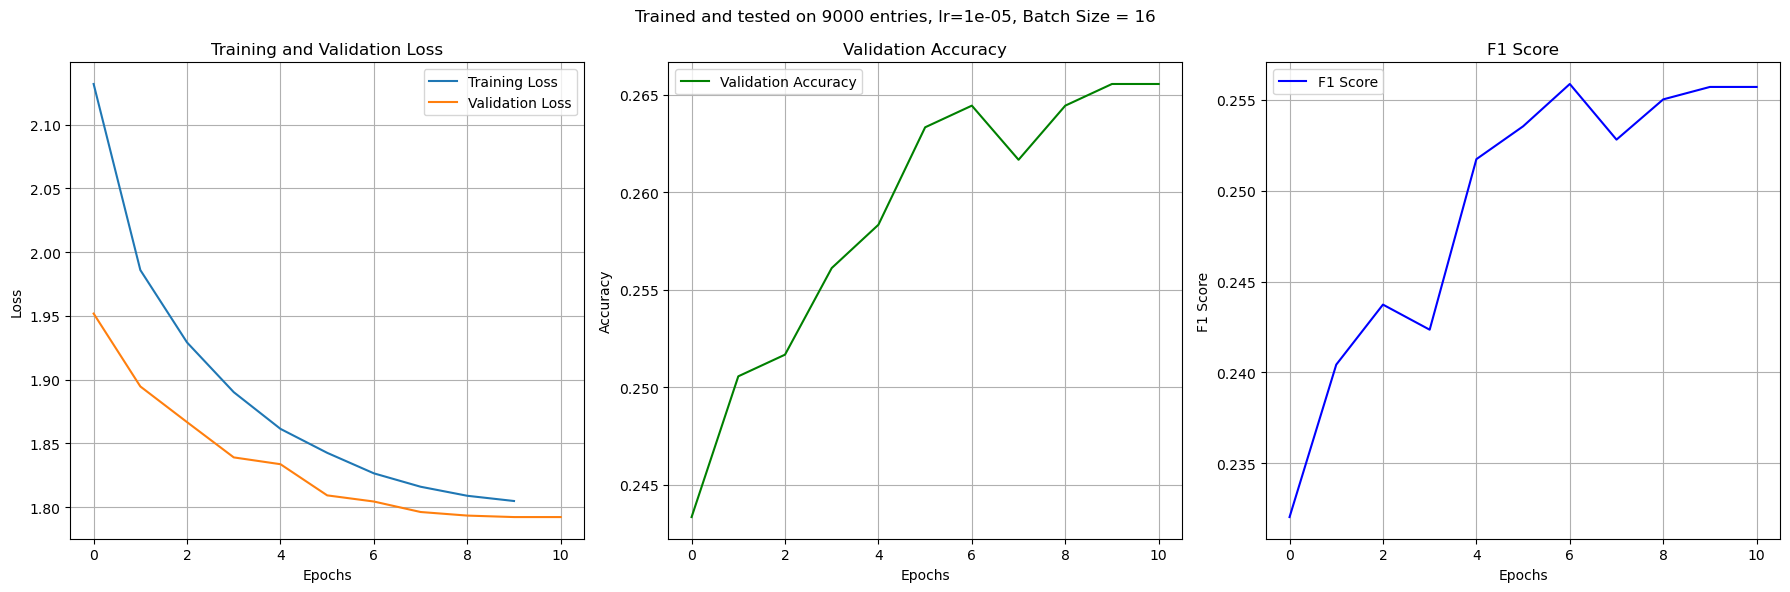

In [14]:
# After training
log_history = trainer.state.log_history

# Extract training and validation loss
train_loss = [entry["loss"] for entry in log_history if "loss" in entry]
eval_loss = [entry["eval_loss"] for entry in log_history if "eval_loss" in entry]
f1 = [entry["eval_f1"] for entry in log_history if "eval_f1" in entry]

# Extract accuracy (if available in compute_metrics)
eval_accuracy = [entry["eval_accuracy"] for entry in log_history if "eval_accuracy" in entry]
import matplotlib.pyplot as plt

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot training and validation loss
axes[0].plot(train_loss, label="Training Loss")
axes[0].plot(eval_loss, label="Validation Loss")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].set_title("Training and Validation Loss")
axes[0].legend()
axes[0].grid()

# Plot validation accuracy (if available)
if eval_accuracy:
    axes[1].plot(eval_accuracy, label="Validation Accuracy", color="green")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Accuracy")
    axes[1].set_title("Validation Accuracy")
    axes[1].legend()
    axes[1].grid()

# Plot F1 score (if available)
if f1:
    axes[2].plot(f1, label="F1 Score", color="blue")
    axes[2].set_xlabel("Epochs")
    axes[2].set_ylabel("F1 Score")
    axes[2].set_title("F1 Score")
    axes[2].legend()
    axes[2].grid()

fig.suptitle(f"Trained and tested on {SAMPLE_SIZE} entries, lr={LEARNING_RATE}, Batch Size = {BATCH_SIZE}", fontsize=12)
plt.tight_layout()
plt.show()
